# Evaluate ensemble

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from transformers import set_seed, Wav2Vec2Processor, Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor, WavLMForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
notebook_path = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_path, '../..'))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


In [4]:
# Set seed for reproducibility
seed = 42
set_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

Load Dataset

In [5]:
df_test = pd.read_csv('../../data/test_dataset.csv')
df_test = df_test[['Filepath', 'Emotion']]

In [6]:
df_test

,Filepath,Emotion
0,./dataset/mlend\MLEndSND_Public\01620.wav,Neutral
1,./dataset/jl-corpus/Raw JL corpus (unchecked a...,Sad
2,./dataset/mlend\MLEndSND_Public\04997.wav,Question
3,./dataset/esd\0018\Surprise\0018_001454.wav,Surprise
4,./dataset/mlend\MLEndSND_Public\05521.wav,Neutral
...,...,...
9472,./dataset/tess\YAF_pleasant_surprised\YAF_half...,Surprise
9473,./dataset/esd\0019\Angry\0019_000651.wav,Anger
9474,./dataset/mlend\MLEndSND_Public\21688.wav,Neutral
9475,./dataset/esd\0020\Angry\0020_000377.wav,Anger


In [7]:
# Convert labels to integers
unique_labels = sorted(df_test['Emotion'].unique())
label_map = {label: idx for idx, label in enumerate(unique_labels)}
print(label_map)

df_test['Emotion'] = df_test['Emotion'].map(label_map)

{'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}


In [8]:
df_test

,Filepath,Emotion
0,./dataset/mlend\MLEndSND_Public\01620.wav,5
1,./dataset/jl-corpus/Raw JL corpus (unchecked a...,7
2,./dataset/mlend\MLEndSND_Public\04997.wav,6
3,./dataset/esd\0018\Surprise\0018_001454.wav,8
4,./dataset/mlend\MLEndSND_Public\05521.wav,5
...,...,...
9472,./dataset/tess\YAF_pleasant_surprised\YAF_half...,8
9473,./dataset/esd\0019\Angry\0019_000651.wav,0
9474,./dataset/mlend\MLEndSND_Public\21688.wav,5
9475,./dataset/esd\0020\Angry\0020_000377.wav,0


Loading pretrained augmented models and meta classifier

In [9]:
# Load Model 1: facebook/wav2vec2-base
model1_checkpoint_path = '../models/wav2vec2-base_standardpad_augmentation/checkpoint-22112'
processor1 = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model1 = Wav2Vec2ForSequenceClassification.from_pretrained(
    model1_checkpoint_path, num_labels=len(label_map))

# Load Model 2: microsoft/wavlm-base
model2_checkpoint_path = '../models/wavlm-base_standardpad_augmentation/checkpoint-55280'
processor2 = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-base")
model2 = WavLMForSequenceClassification.from_pretrained(
    model2_checkpoint_path, num_labels=len(label_map))

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\transformers\configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [10]:
from transformer_models.meta_learner.MetaLearner import MetaFFNN

# Load model
meta_classifier_model = MetaFFNN(input_dim=18, hidden_dim=128, output_dim=9)
meta_classifier_model.load_state_dict(torch.load('../models/best_meta_ffnn_model.pt'))

C:\Users\profi\AppData\Local\Temp\ipykernel_46700\311361715.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta_classifier_model.load_state_dict(torch.load('../models/b

<All keys matched successfully>

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.eval()
model1.to(device)
model2.eval()
model2.to(device)
meta_classifier_model.eval()
meta_classifier_model.to(device)

MetaFFNN(
  (model): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=9, bias=True)
  )
)

Prepare test dataset

In [12]:
from transformer_models.emotion_datasets.SpeechEmotionDatasetStandardPad import SpeechEmotionDatasetStandardPad

# Create two test datasets, one for each model
test_dataset1 = SpeechEmotionDatasetStandardPad(df_test, processor1)
test_dataset2 = SpeechEmotionDatasetStandardPad(df_test, processor2)

In [13]:
test_dataset1[0]

Keyword argument `truncate` is not a valid argument for this processor and will be ignored.


{'input_values': tensor([ 0.0045, -0.0713,  0.0061,  ...,  0.0004,  0.0004,  0.0004]),
 'labels': tensor(5)}

In [14]:
test_dataset2[0]

{'input_values': tensor([ 0.0001, -0.0024,  0.0002,  ...,  0.0000,  0.0000,  0.0000]),
 'labels': tensor(5)}

Get predictions from each model

In [15]:
def get_base_logits(model, dataloader, device):
    """
    Obtain logits from the given base model over the test set.
    """
    model.eval()
    logits_list = []
    labels_list = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_values = batch["input_values"].to(device)
            outputs = model(input_values)
            # Directly obtain logits without applying softmax
            logits = outputs.logits
            logits_list.append(logits.cpu())
            labels_list.append(batch["labels"].cpu())
    
    return torch.cat(logits_list, dim=0), torch.cat(labels_list, dim=0)


In [16]:
def construct_meta_features(logits1, logits2):
    """
    Concatenate the raw logits from both models.
    """
    # Concatenate along the last dimension, e.g., logits1 and logits2 each of shape [N, 9]
    meta_features = torch.cat([logits1, logits2], dim=-1)
    return meta_features

In [17]:
# Create DataLoaders for the test datasets
batch_size = 128
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)

# Get logits and ground truth from the base models
logits1, ground_truth = get_base_logits(model1, test_loader1, device)
print(len(ground_truth))
logits2, _ = get_base_logits(model2, test_loader2, device)
print(logits1.shape, logits2.shape)

meta_features = construct_meta_features(logits1, logits2).to(device)
print(meta_features.shape)

# Run the meta-classifier on the concatenated logits
with torch.no_grad():
    meta_outputs = meta_classifier_model(meta_features)
    # Get ensemble predictions by taking the highest scoring logit for each sample
    meta_preds = torch.argmax(meta_outputs, dim=-1).cpu().numpy()
print(meta_preds.shape)


c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\transformer_models\emotion_datasets\SpeechEmotionDatasetStandardPad.py:22: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, sr = librosa.load(audio_path, sr=16000)
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


9477
torch.Size([9477, 9]) torch.Size([9477, 9])
torch.Size([9477, 18])
(9477,)


Test Accuracy: 0.8611
Test Precision: 0.8729
Test Recall: 0.8611
Test F1-score: 0.8641

              precision    recall  f1-score   support

       Anger       0.89      0.88      0.89       916
       Bored       0.90      0.94      0.92      1098
     Disgust       0.64      0.78      0.70       291
        Fear       0.52      0.82      0.63       308
       Happy       0.94      0.83      0.88      1914
     Neutral       0.83      0.85      0.84      2226
    Question       0.97      0.95      0.96      1139
         Sad       0.93      0.77      0.84       857
    Surprise       0.79      0.86      0.82       728

    accuracy                           0.86      9477
   macro avg       0.82      0.85      0.83      9477
weighted avg       0.87      0.86      0.86      9477



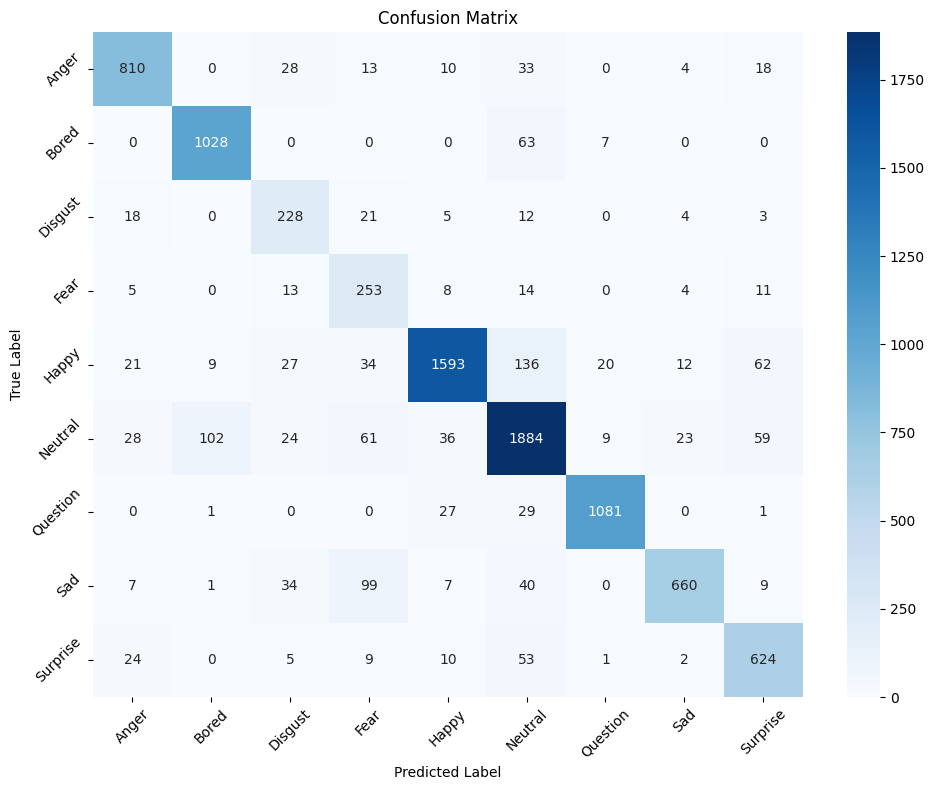

In [18]:
# Compute metrics: accuracy, precision, recall, and F1 score
accuracy = accuracy_score(ground_truth, meta_preds)
precision, recall, f1, _ = precision_recall_fscore_support(ground_truth, meta_preds, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-score: {f1:.4f}\n")

# Detailed classification report
print(classification_report(ground_truth, meta_preds, target_names=list(label_map.keys())))

# Compute the confusion matrix
conf_matrix = confusion_matrix(ground_truth, meta_preds)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label_map.keys()),
            yticklabels=list(label_map.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()